# Homework - Principal Components Analysis


## Libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib as plt
import yaml
from matplotlib import cm 
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder   
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

## 0. Preparation (Setting the Random State):

In [65]:
pellegrino = 331438
mungaicoppolino = 246120
rs = min(pellegrino, mungaicoppolino)
np.random.seed(rs)
initial_random_state = np.random.get_state()
np.random.set_state(initial_random_state)

## 1. Loading and Preparing the Data


### 1.1 Storing the csv file in a DataFrame Variable

We store in the variable df_tot the dataframe obtained from the csv file.

In [66]:
df_tot = pd.read_csv("cla4lsp_customers.csv", sep='\t')
df_tot.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### 1.2 Sub-DFs Creation

Creation of the sub dataframes *workdf*: 2/3 of the rows are taken from the original dataframes df_tot

In [67]:
workdf = df_tot.sample(frac=2/3, random_state=rs)
workdf.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
762,6406,1988,Master,Married,78285.0,0,0,28-10-2013,13,647,...,3,0,0,0,0,0,0,3,11,0
2206,1092,1980,Graduation,Married,61014.0,0,1,11-08-2012,17,269,...,7,0,0,0,0,0,0,3,11,0
419,8581,1971,Master,Married,49505.0,1,1,05-03-2013,4,604,...,8,0,0,0,0,0,0,3,11,0
1370,5948,1975,Graduation,Single,57338.0,0,1,29-04-2014,96,143,...,5,0,0,0,0,0,0,3,11,0
1775,8910,1955,Graduation,Together,42586.0,1,1,29-10-2012,7,194,...,8,0,0,0,0,0,0,3,11,1


### 1.3 Labels and Features

Discarding the ID, Z_CostContact and Z_Revenue columns

In [68]:
labels = ['NumDealsPurchases',
'AcceptedCmp1',
'AcceptedCmp2',
'AcceptedCmp3',
'AcceptedCmp4',
'AcceptedCmp5',
'Response',
'Complain',
'Recency'] #len(labels) == 9

features = [
    'Year_Birth',
    'Education',
    'Marital_Status',
    'Income',
    'Kidhome',
    'Teenhome',
    'Dt_Customer',
    'MntWines', 
    'MntFruits', 
    'MntMeatProducts',
    'MntFishProducts',
    'MntSweetProducts', 
    'MntGoldProds', 
    'NumWebPurchases', 
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumWebVisitsMonth'
] #len(features) == 17 
workdf = workdf.loc[:, labels + features]
workdf.head()


,NumDealsPurchases,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Complain,Recency,Year_Birth,...,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
762,1,0,0,0,0,0,0,0,13,1988,...,647,107,391,175,67,40,6,4,10,3
2206,4,0,0,0,0,0,0,0,17,1980,...,269,129,495,182,43,29,9,3,4,7
419,9,0,0,0,0,0,0,0,4,1971,...,604,0,100,19,0,28,10,2,8,8
1370,2,0,0,0,0,0,0,0,96,1975,...,143,6,52,11,8,17,4,1,5,5
1775,5,0,0,0,0,0,1,0,7,1955,...,194,2,56,0,0,0,4,1,6,8


### 1.4 Removing randomly from workdf one feature

In [69]:
purchase_features = ['MntWines', 
                    'MntFruits', 
                    'MntMeatProducts',
                    'MntFishProducts',
                    'MntSweetProducts', 
                    'MntGoldProds', 
                    'NumWebPurchases', 
                    'NumCatalogPurchases',
                    'NumStorePurchases']

removed_feature = np.random.choice(purchase_features)
workdf = workdf.drop(columns=removed_feature)
features.remove(removed_feature)
print(f"Feature removed: {removed_feature}\nFirst elements of the workdf Dataframes:")
display(workdf.head())



Feature removed: NumStorePurchases
First elements of the workdf Dataframes:


,NumDealsPurchases,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Complain,Recency,Year_Birth,...,Dt_Customer,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumWebVisitsMonth
762,1,0,0,0,0,0,0,0,13,1988,...,28-10-2013,647,107,391,175,67,40,6,4,3
2206,4,0,0,0,0,0,0,0,17,1980,...,11-08-2012,269,129,495,182,43,29,9,3,7
419,9,0,0,0,0,0,0,0,4,1971,...,05-03-2013,604,0,100,19,0,28,10,2,8
1370,2,0,0,0,0,0,0,0,96,1975,...,29-04-2014,143,6,52,11,8,17,4,1,5
1775,5,0,0,0,0,0,1,0,7,1955,...,29-10-2012,194,2,56,0,0,0,4,1,8


### 1.5 Clean the dataset workdf

NaN value were found in the column *'Income'*. For sake of simplicity, rows with NaN value in that column are suppressed.

In [70]:
tmp_df = workdf.loc[:, features]
df_nan = tmp_df[tmp_df.isna().any(axis=1)]
print("Dataframes where there are NaN values (df_nan):\n")
display(df_nan)
workdf = workdf.dropna()
print("workdf without df_nan:\n")
display(workdf)

Dataframes where there are NaN values (df_nan):



,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumWebVisitsMonth
58,1982,Graduation,Single,NaN,1,0,17-06-2013,11,3,22,2,2,6,2,0,6
1382,1958,Graduation,Together,NaN,1,1,03-09-2012,19,4,12,2,2,6,1,0,5
71,1973,2n Cycle,Married,NaN,1,0,14-09-2012,25,3,43,17,4,17,3,0,8
90,1957,PhD,Married,NaN,2,1,19-11-2012,230,42,192,49,37,53,7,2,9
133,1963,Graduation,Married,NaN,0,1,11-08-2013,231,65,196,38,71,124,6,5,4
1386,1972,PhD,Together,NaN,1,0,02-03-2014,25,1,13,0,0,3,1,0,7
312,1989,Graduation,Married,NaN,0,0,03-06-2013,861,138,461,60,30,61,6,5,3
2061,1981,PhD,Single,NaN,1,0,31-05-2013,23,0,15,0,2,7,3,0,6
10,1983,Graduation,Married,NaN,1,0,15-11-2013,5,5,6,0,2,1,1,0,7
48,1951,Graduation,Single,NaN,2,1,01-01-2014,48,5,48,6,10,7,2,1,6


workdf without df_nan:



,NumDealsPurchases,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Complain,Recency,Year_Birth,...,Dt_Customer,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebPurchases,NumCatalogPurchases,NumWebVisitsMonth
762,1,0,0,0,0,0,0,0,13,1988,...,28-10-2013,647,107,391,175,67,40,6,4,3
2206,4,0,0,0,0,0,0,0,17,1980,...,11-08-2012,269,129,495,182,43,29,9,3,7
419,9,0,0,0,0,0,0,0,4,1971,...,05-03-2013,604,0,100,19,0,28,10,2,8
1370,2,0,0,0,0,0,0,0,96,1975,...,29-04-2014,143,6,52,11,8,17,4,1,5
1775,5,0,0,0,0,0,1,0,7,1955,...,29-10-2012,194,2,56,0,0,0,4,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,1,0,0,1,0,0,0,0,90,1955,...,27-04-2013,18,2,10,0,0,25,1,1,7
358,1,0,0,0,0,0,0,1,65,1943,...,20-08-2013,629,17,177,69,0,8,5,3,2
1118,1,0,0,0,0,0,0,0,47,1966,...,16-01-2013,2,23,11,8,6,46,2,1,8
1520,1,0,0,0,0,0,1,0,73,1983,...,03-06-2013,910,111,724,49,74,55,10,2,3


## 2. Exercise 2 (Encoding of Categorical Data)

In [71]:
OHE = OneHotEncoder()
transformed = OHE.fit_transform(workdf.loc[:, ['Education', 'Marital_Status']])
# stiamo aggiungendo delle nuove colonne usando i titoli creati dal transformer e i dati transformati salvati come array
workdf[OHE.get_feature_names_out()] = transformed.toarray()
workdf = workdf.drop(columns=['Education', 'Marital_Status'])

features = [item for item in features if item not in ['Education', 'Marital_Status', 'Dt_Customer']]
features = features + list(OHE.get_feature_names_out())

display(workdf)

,NumDealsPurchases,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Complain,Recency,Year_Birth,...,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
762,1,0,0,0,0,0,0,0,13,1988,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2206,4,0,0,0,0,0,0,0,17,1980,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
419,9,0,0,0,0,0,0,0,4,1971,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1370,2,0,0,0,0,0,0,0,96,1975,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1775,5,0,0,0,0,0,1,0,7,1955,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,1,0,0,1,0,0,0,0,90,1955,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
358,1,0,0,0,0,0,0,1,65,1943,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1118,1,0,0,0,0,0,0,0,47,1966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1520,1,0,0,0,0,0,1,0,73,1983,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Dt_customer is handled differently. Major importance to old data, rescaled from 0 to 600

In [72]:
column_names = ['Dt_Customer_Day', 'Dt_Customer_Month', 'Dt_Customer_Year']

# Split the column into three columns: 'Day', 'Month', 'Year'
workdf[column_names] = workdf['Dt_Customer'].str.split('-', expand=True)


workdf[column_names] = workdf[column_names].astype(int)

workdf = workdf.drop(columns='Dt_Customer')

features = features + column_names
display(workdf.columns)
display(features)


Index(['NumDealsPurchases', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain', 'Recency',
       'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumWebVisitsMonth', 'Education_2n Cycle', 'Education_Basic',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Marital_Status_YOLO', 'Dt_Customer_Day',
       'Dt_Customer_Month', 'Dt_Customer_Year'],
      dtype='object')

['Year_Birth',
 'Income',
 'Kidhome',
 'Teenhome',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumWebVisitsMonth',
 'Education_2n Cycle',
 'Education_Basic',
 'Education_Graduation',
 'Education_Master',
 'Education_PhD',
 'Marital_Status_Absurd',
 'Marital_Status_Alone',
 'Marital_Status_Divorced',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Marital_Status_Together',
 'Marital_Status_Widow',
 'Marital_Status_YOLO',
 'Dt_Customer_Day',
 'Dt_Customer_Month',
 'Dt_Customer_Year']

Now Xworkdf

In [73]:
Xworkdf = workdf[features]
#display(Xworkdf)

## 3. Exercise 3 (Preprocessing and full-PCA)

Creation of the two DFs *Xworkdf_std* and *Xworksf_mm*, created using a StandardScaler and a MinMaxScaler

In [74]:
SScaler = StandardScaler()
MMScaler = MinMaxScaler()

Xworkdf_std = SScaler.fit_transform(Xworkdf)
Xworkdf_mm = MMScaler.fit_transform(Xworkdf)

Xworkdf_std = pd.DataFrame(Xworkdf_std, columns=Xworkdf.columns)
Xworkdf_mm = pd.DataFrame(Xworkdf_mm, columns=Xworkdf.columns)

In [75]:
Xworkdf_mm

,Year_Birth,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Dt_Customer_Day,Dt_Customer_Month,Dt_Customer_Year
0,0.922330,0.476482,0.0,0.0,0.433356,0.537688,0.226667,0.675676,0.255725,0.124611,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.900000,0.818182,0.5
1,0.844660,0.368987,0.0,0.5,0.180174,0.648241,0.286957,0.702703,0.164122,0.090343,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.636364,0.0
2,0.757282,0.297354,0.5,0.5,0.404555,0.000000,0.057971,0.073359,0.000000,0.087227,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.133333,0.181818,0.5
3,0.796117,0.346107,0.0,0.5,0.095780,0.030151,0.030145,0.042471,0.030534,0.052960,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.933333,0.272727,1.0
4,0.601942,0.254290,0.5,0.5,0.129940,0.010050,0.032464,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.933333,0.818182,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1472,0.601942,0.221041,0.5,0.5,0.012056,0.010050,0.005797,0.000000,0.000000,0.077882,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.866667,0.272727,0.5
1473,0.485437,0.394250,0.0,0.0,0.421299,0.085427,0.102609,0.266409,0.000000,0.024922,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.633333,0.636364,0.5
1474,0.708738,0.130108,0.0,0.0,0.001340,0.115578,0.006377,0.030888,0.022901,0.143302,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.500000,0.000000,0.5
1475,0.873786,0.531895,0.0,0.0,0.609511,0.557789,0.419710,0.189189,0.282443,0.171340,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.066667,0.454545,0.5


In [76]:
np.array(Xworkdf.var())

array([1.51408151e+02, 4.80455196e+08, 2.89490342e-01, 2.89463738e-01,
       1.11702565e+05, 1.66387483e+03, 5.04766621e+04, 2.94868232e+03,
       1.70392911e+03, 2.69471048e+03, 7.94848288e+00, 8.76933761e+00,
       6.04991716e+00, 8.64089480e-02, 2.63663436e-02, 2.50160088e-01,
       1.41155349e-01, 1.66338234e-01, 6.77048070e-04, 2.02839198e-03,
       9.61270649e-02, 2.35058613e-01, 1.70978490e-01, 1.93817395e-01,
       2.95589280e-02, 6.77048070e-04, 7.58579896e+01, 1.20045770e+01,
       4.80778440e-01])

In [77]:
np.array(Xworkdf.var())

array([1.51408151e+02, 4.80455196e+08, 2.89490342e-01, 2.89463738e-01,
       1.11702565e+05, 1.66387483e+03, 5.04766621e+04, 2.94868232e+03,
       1.70392911e+03, 2.69471048e+03, 7.94848288e+00, 8.76933761e+00,
       6.04991716e+00, 8.64089480e-02, 2.63663436e-02, 2.50160088e-01,
       1.41155349e-01, 1.66338234e-01, 6.77048070e-04, 2.02839198e-03,
       9.61270649e-02, 2.35058613e-01, 1.70978490e-01, 1.93817395e-01,
       2.95589280e-02, 6.77048070e-04, 7.58579896e+01, 1.20045770e+01,
       4.80778440e-01])

In [78]:
Xworkdf_mm.mean()

Year_Birth                 0.735281
Income                     0.309448
Kidhome                    0.224103
Teenhome                   0.250508
MntWines                   0.198458
MntFruits                  0.133171
MntMeatProducts            0.094333
MntFishProducts            0.141378
MntSweetProducts           0.101565
MntGoldProds               0.132729
NumWebPurchases            0.149828
NumCatalogPurchases        0.092465
NumWebVisitsMonth          0.268957
Education_2n Cycle         0.095464
Education_Basic            0.027082
Education_Graduation       0.496953
Education_Master           0.169939
Education_PhD              0.210562
Marital_Status_Absurd      0.000677
Marital_Status_Alone       0.002031
Marital_Status_Divorced    0.107651
Marital_Status_Married     0.377116
Marital_Status_Single      0.218687
Marital_Status_Together    0.262695
Marital_Status_Widow       0.030467
Marital_Status_YOLO        0.000677
Dt_Customer_Day            0.492868
Dt_Customer_Month          0

Below are shown the plots of *Xworkdf*,

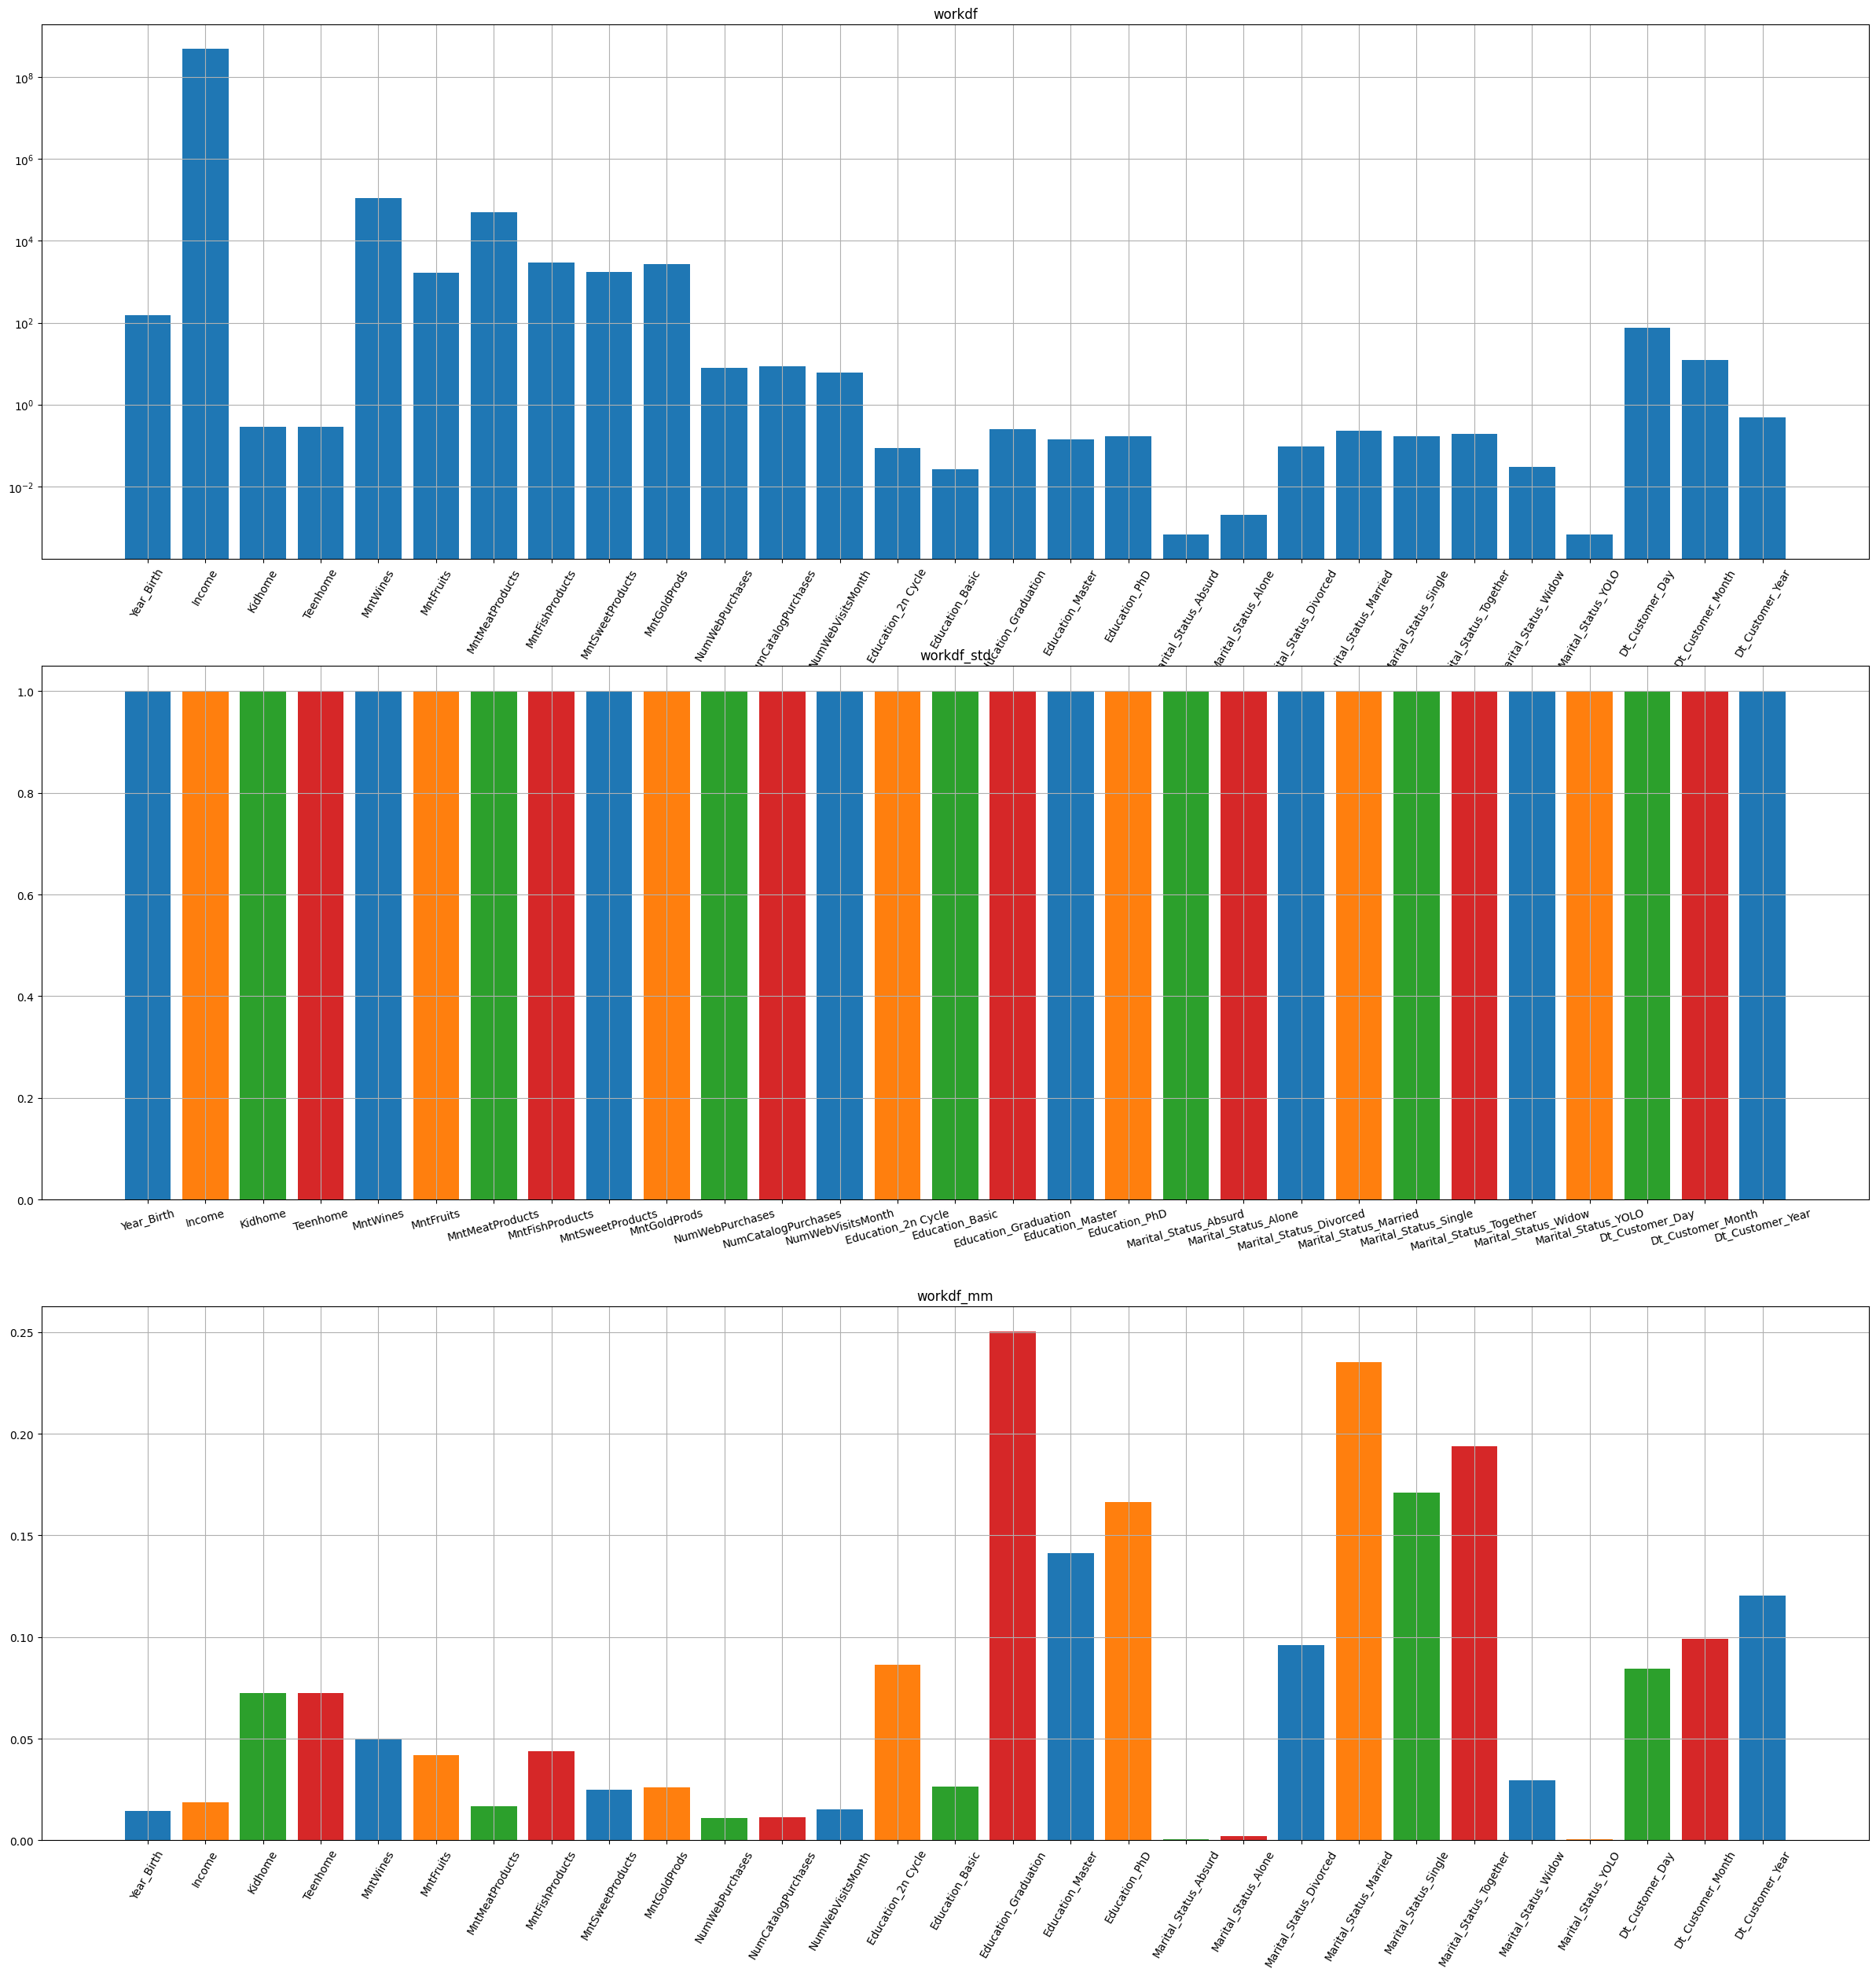

In [79]:
tab10 = cm.tab10.colors

fig, ax = plt.subplots(3, 1, figsize=(30, 30))
ax[0].bar(np.arange(Xworkdf.shape[1]), np.array(Xworkdf.var()))
ax[0].set_xticks(ticks=np.arange(Xworkdf.shape[1]), 
           labels=Xworkdf.columns.to_list(),
           rotation=60)
ax[0].set_title('workdf')
ax[0].set_yscale('log')
ax[0].grid(visible=True, which='both')

ax[1].bar(np.arange(Xworkdf.shape[1]), Xworkdf_std.var(), color=tab10[:4])
ax[1].set_xticks(ticks=np.arange(Xworkdf.shape[1]), 
           labels=Xworkdf.columns.to_list(),
           rotation=15)
ax[1].set_title('workdf_std')
ax[1].grid(visible=True, which='both')

ax[2].bar(np.arange(Xworkdf.shape[1]), Xworkdf_mm.var(), color=tab10[:4])
ax[2].set_xticks(ticks=np.arange(Xworkdf.shape[1]), 
           labels=Xworkdf.columns.to_list(),
           rotation=60)
ax[2].set_title('workdf_mm')
ax[2].grid(visible=True, which='both')



plt.show()



PCA

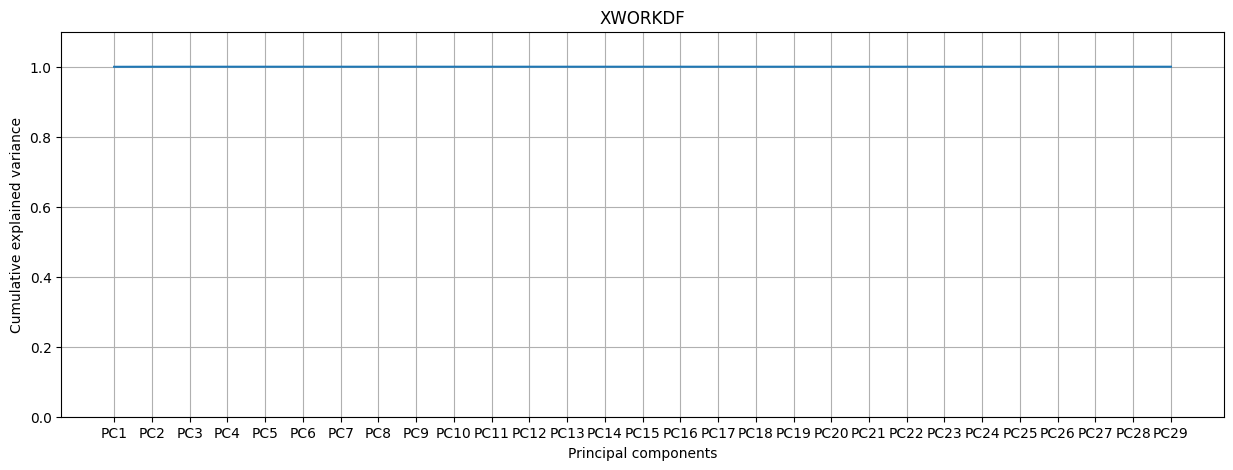

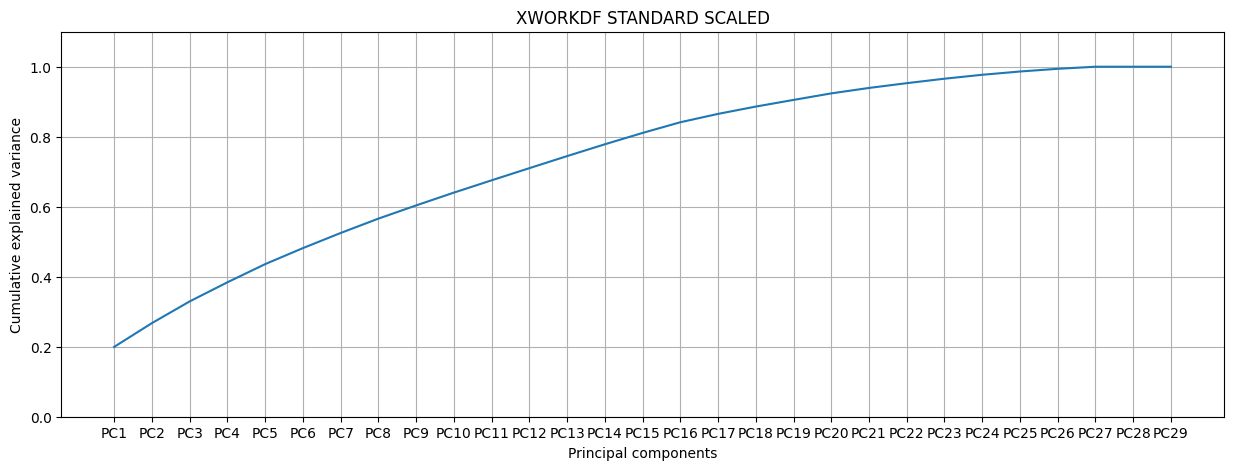

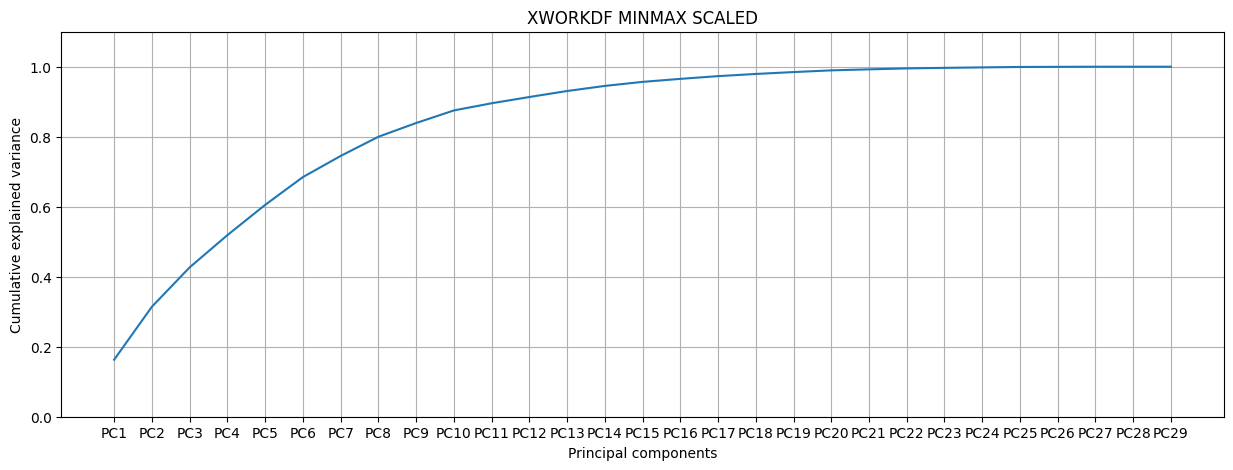

In [80]:
pca_nostd = PCA()
pca_ss = PCA()
pca_mm = PCA()

pca_nostd.fit(Xworkdf)
pca_ss.fit(Xworkdf_std)
pca_mm.fit(Xworkdf_mm)

explained_variance_ss = np.cumsum(pca_ss.explained_variance_ratio_)
explained_variance_mm = np.cumsum(pca_mm.explained_variance_ratio_)

#pca_nostd
plt.figure(figsize=(15, 5))
plt.plot(np.cumsum(pca_nostd.explained_variance_ratio_))
plt.title('XWORKDF')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_nostd.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca_nostd.n_features_)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()


#pca_ss
plt.figure(figsize=(15, 5))
plt.plot(np.cumsum(pca_ss.explained_variance_ratio_))
plt.title('XWORKDF STANDARD SCALED')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_ss.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca_ss.n_features_)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()

#pca_mm
plt.figure(figsize=(15, 5))
plt.plot(np.cumsum(pca_mm.explained_variance_ratio_))
plt.title('XWORKDF MINMAX SCALED')
plt.ylim([0, 1.1])
plt.xticks(ticks=np.arange(pca_mm.n_features_), 
           labels=[f'PC{i + 1}' for i in range(pca_mm.n_features_)])
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.grid()
plt.show()


In [81]:
np.cumsum(pca_ss.explained_variance_ratio_)

array([0.19946015, 0.26736271, 0.32937042, 0.38397058, 0.43589564,
       0.48168114, 0.52488729, 0.56590551, 0.60365979, 0.64024483,
       0.6753588 , 0.710107  , 0.74455044, 0.77834188, 0.81078854,
       0.84131674, 0.86521634, 0.88612174, 0.90513092, 0.92381357,
       0.93936659, 0.95301878, 0.96575417, 0.97696819, 0.98634304,
       0.99405936, 1.        , 1.        , 1.        ])

m' is the minimum number of PCs that explains 33% of the total variance.

In [82]:
# argmax = indice del primo elemento di un array > di un treshold
m_prime_ss = np.argmax(explained_variance_ss > 0.33) + 1
m_prime_mm = np.argmax(explained_variance_mm > 0.33) + 1

m_ss = min(m_prime_ss, 5)
m_mm = min(m_prime_mm, 5)

pca_ss = PCA(n_components=m_ss)
pca_mm = PCA(n_components=m_mm)

Y_Xworkdf_std = pca_ss.fit_transform(Xworkdf_std)
Y_Xworkdf_mm = pca_mm.fit_transform(Xworkdf_mm)




pca_ss

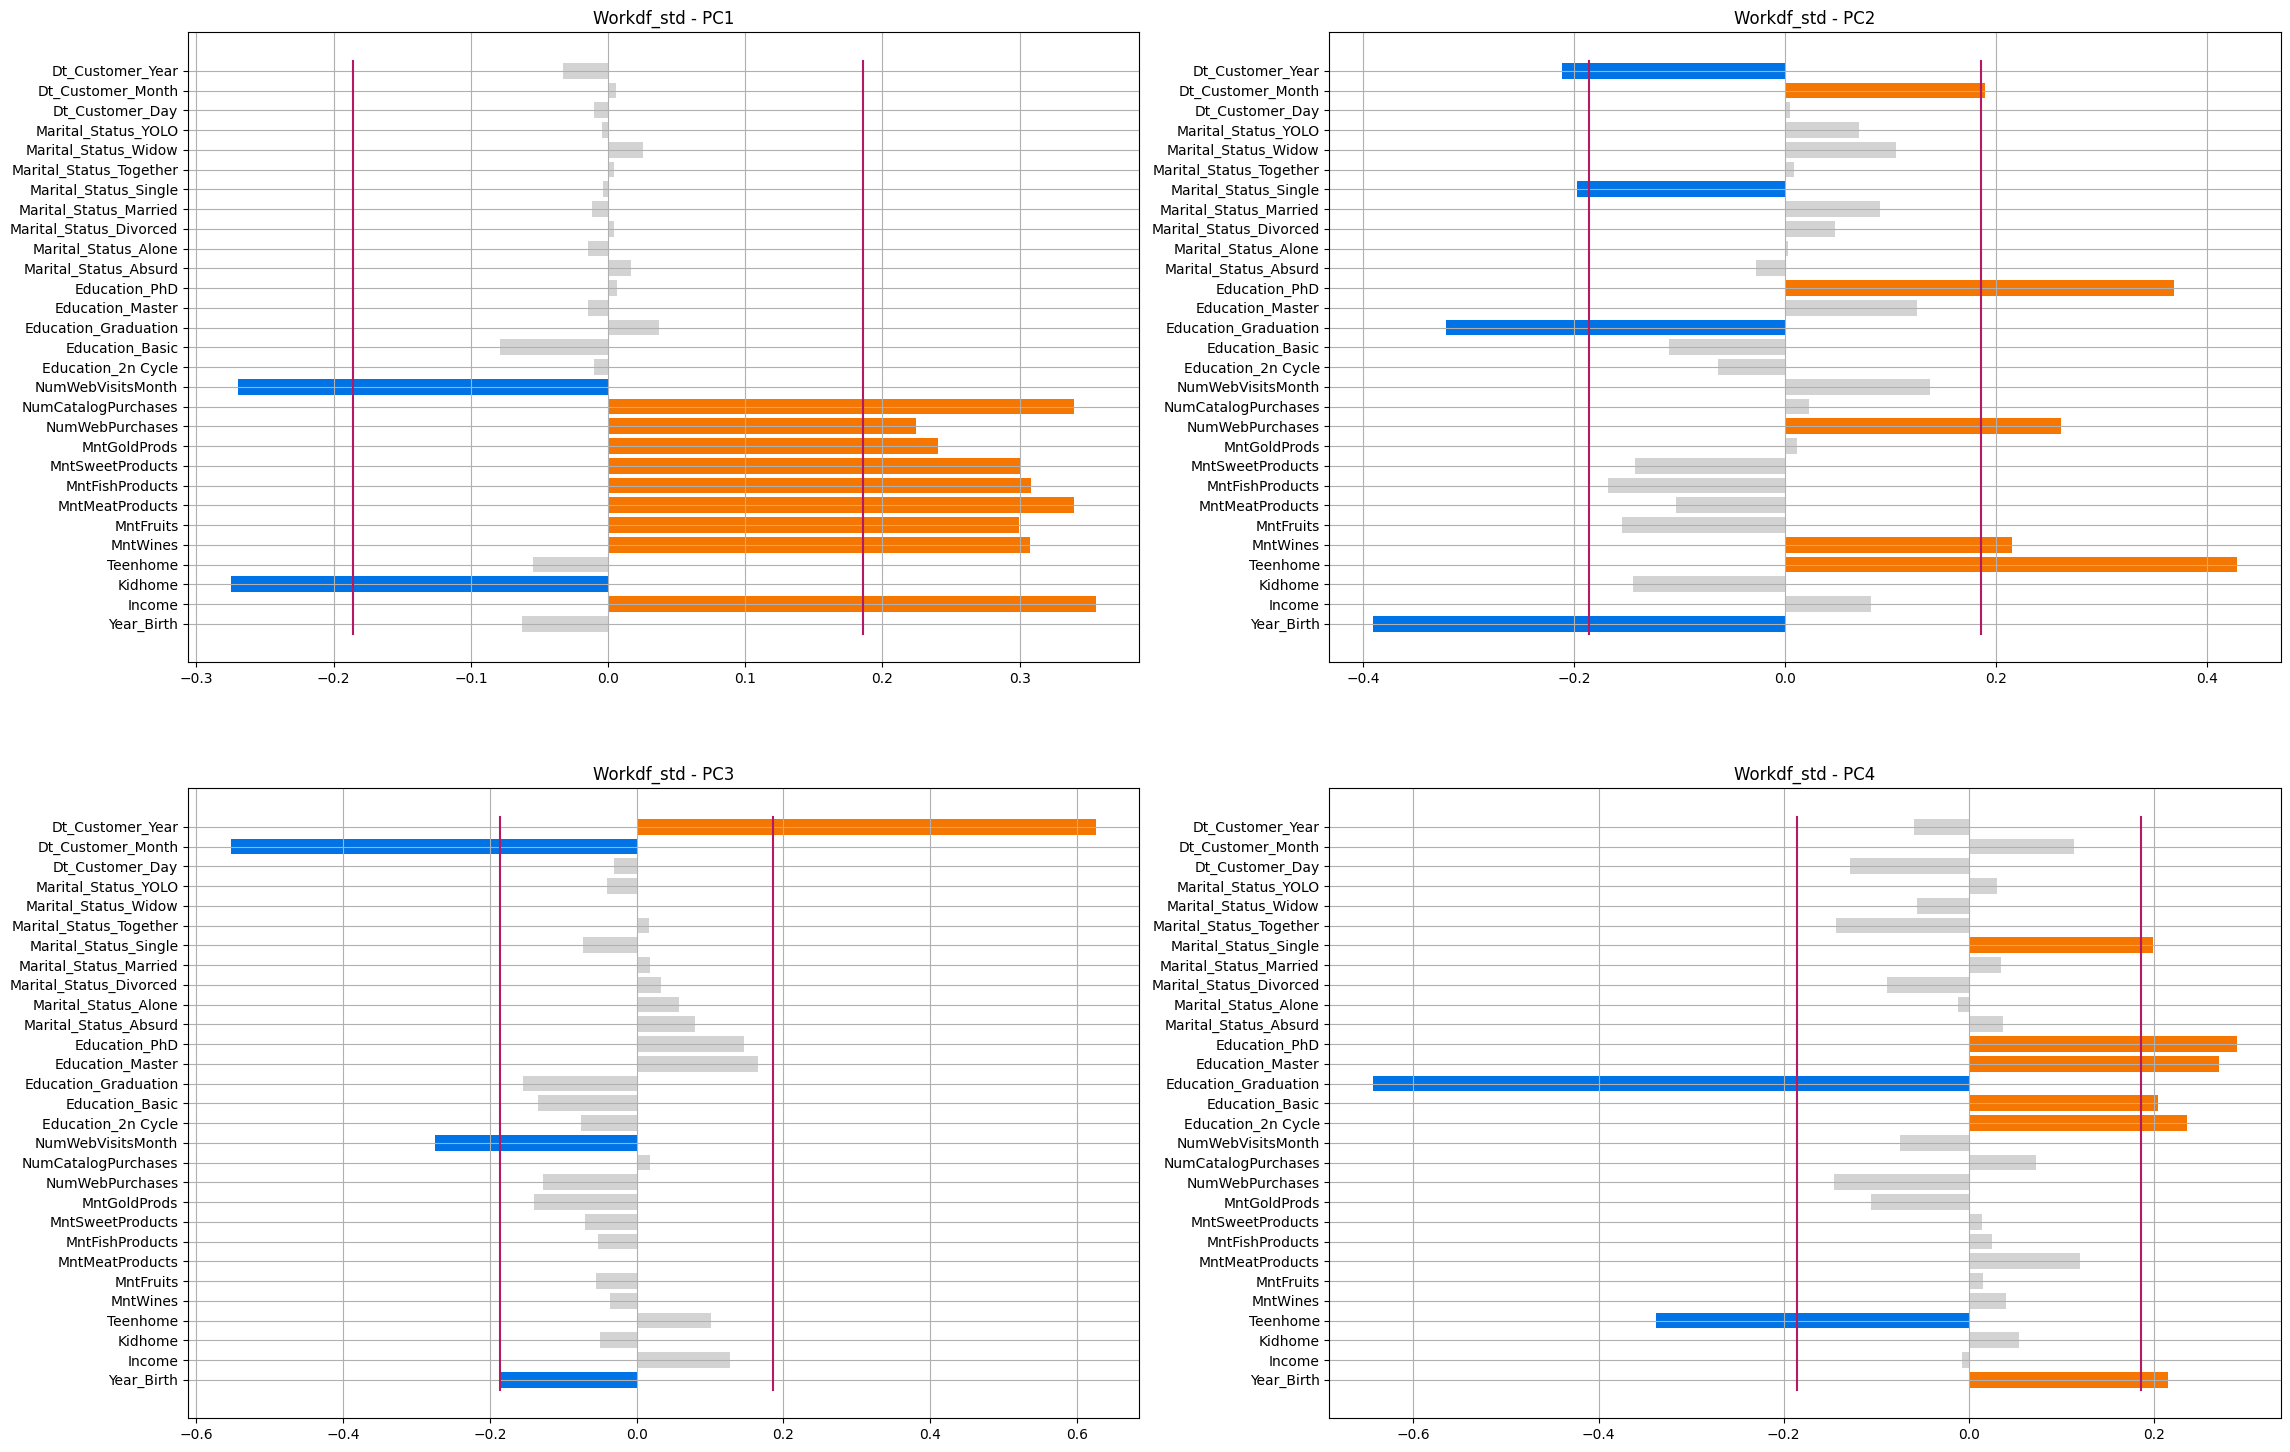

-0.18585434494732073

In [83]:
eps = np.sqrt(1 / Xworkdf.shape[1])

fig, ax = plt.subplots(2, 2, figsize=(27, 18))
num = 0
for i in range(0, 2):
    for j in range(0, 2):
        ax[i,j].plot([eps, eps], [-0.5, pca_ss.n_features_ - 0.5], '#b51963')
        ax[i,j].plot([-eps, -eps], [-0.5, pca_ss.n_features_ - 0.5],'#b51963')
        color_list = ['#F57600' if val >= eps else '#0073E6' if val <= -eps else '#D3D3D3' for val in pca_ss.components_[num, :]]
        ax[i,j].barh(np.arange(pca_ss.n_features_), pca_ss.components_[num, :], color=color_list)
        ax[i,j].set_yticks(ticks=np.arange(pca_ss.n_features_))
        ax[i,j].set_yticklabels(labels=Xworkdf_std.columns.to_list())
        ax[i,j].set_title('Workdf_std - PC%d' % (num+1))
        ax[i,j].grid()
        

        num += 1

plt.show()
display(pca_ss.components_[2, 0])

pca_mm

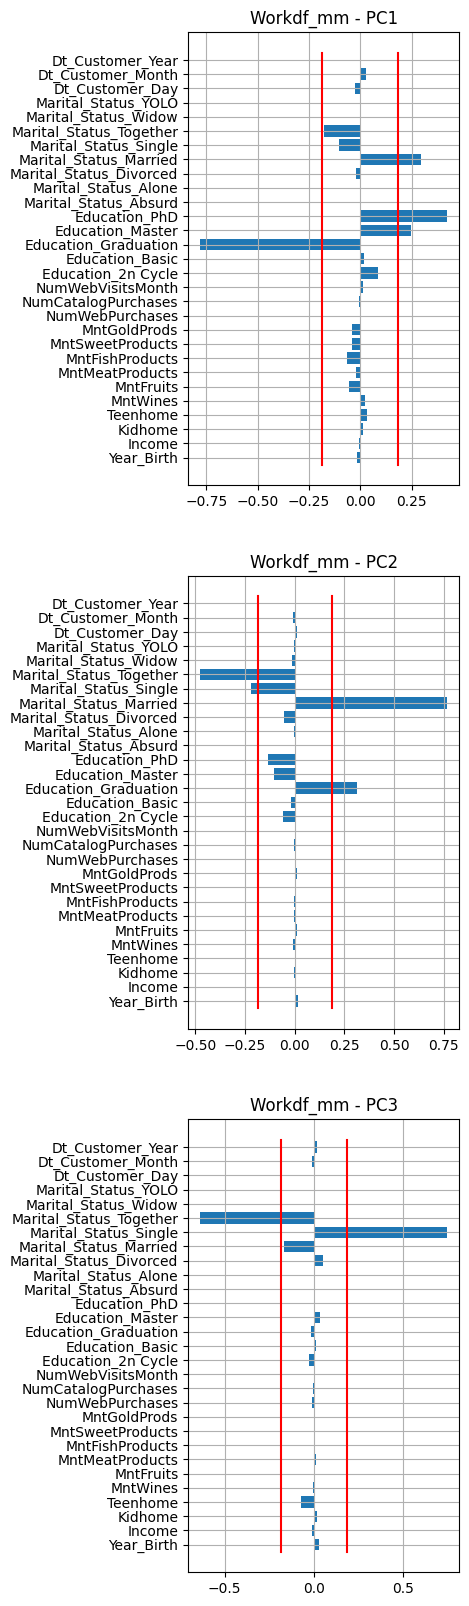

In [84]:
eps = np.sqrt(1 / Xworkdf.shape[1])

fig, ax = plt.subplots(m_mm, 1, figsize=(3.5, 20))
for i in range(0, m_mm):
        ax[i].plot([eps, eps], [-0.5, pca_mm.n_features_ - 0.5], 'red')
        ax[i].plot([-eps, -eps], [-0.5, pca_mm.n_features_ - 0.5],'red')
        ax[i].barh(np.arange(pca_mm.n_features_), pca_mm.components_[i, :])
        ax[i].set_yticks(ticks=np.arange(pca_mm.n_features_))
        ax[i].set_yticklabels(labels=Xworkdf_mm.columns.to_list())
        ax[i].set_title('Workdf_mm - PC%d' % (i+1))
        ax[i].grid()

plt.show()

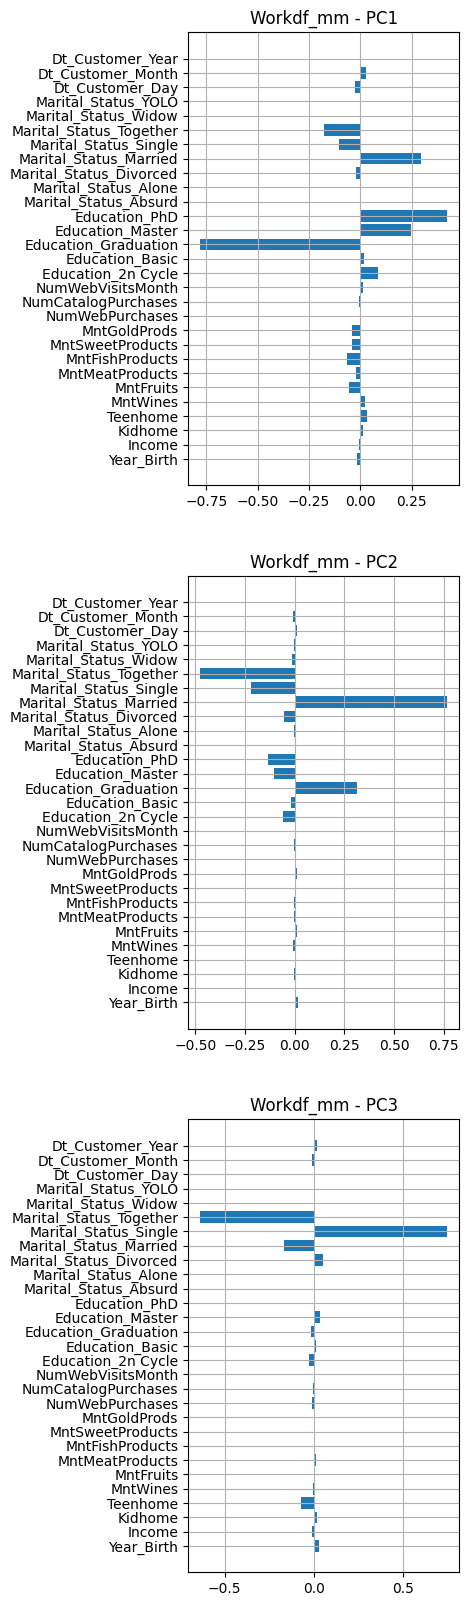

In [85]:
fig, ax = plt.subplots(m_mm, 1, figsize=(3.5, 20))
for i in range(0, m_mm):
        ax[i].barh(np.arange(pca_mm.n_features_), pca_mm.components_[i, :])
        ax[i].set_yticks(ticks=np.arange(pca_mm.n_features_))
        ax[i].set_yticklabels(labels=Xworkdf_mm.columns.to_list())
        ax[i].set_title('Workdf_mm - PC%d' % (i+1))
        ax[i].grid()

plt.show()